# Self-Driving Car Engineer Nanodegree

## Project 2: German Traffic Sign Recognition Benchmark (GTSRB)

---
## Load The Data

In [3]:
# Load pickled data
import pickle
import numpy as np
import csv


training_file = "./data/train.p"
validation_file= "./data/valid.p"
testing_file = "./data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
c_train, c_test = train['coords'], test['coords']

---

## Dataset Summary, Exploration & Pre-Processing

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

For this project, coordinates and sizes will not be used. Training on bounding box images would likely help boost accuracy, but to effectively generalize on new images (which are not in the test set) these would need cropping as well, which would necessitate fitting bounding boxes to new images on the fly.

### High-Level Summary of Data Set

In [4]:
### High-Level Summary Image Data

n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
n_classes = len(set(y_train))
image_shape = X_train.shape[1:]

grp = np.bincount(y_train)
c_max = np.max(grp)
c_min = np.min(grp)
c_std = int(np.std(grp))
c_ave = int(np.average(grp))


print('')
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Number of classes =", n_classes)
print('')
print("Max label count =", c_max)
print("Min label count =", c_min)
print("Average label count =", c_ave)
print("Standard Deviation =", c_std)
print('')
print("Image data shape =", image_shape)
print('')


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Number of classes = 43

Max label count = 2010
Min label count = 180
Average label count = 809
Standard Deviation = 619

Image data shape = (32, 32, 3)



### Exploratory Visualization of Dataset

In [5]:
##Data Exploration##

import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

def plot_hist(labels):
    label, counts = np.unique(labels, return_counts=True)
    
    plt.rcParams["figure.figsize"] = [15,5]
    ax = plt.gca()
    ax.set_xlim([-1,43])
    
    plt.bar(label, counts, tick_label=label, width=0.75, align='center')
    plt.title('Histogram of Label Data')
    plt.show()

def display_images(images, labels):
    assert len(images) == len(labels)

    n_classes = len(set(labels))
    n_images = images.shape[0] 
    rows = n_classes//8+1
    fig = plt.figure(figsize=(8*3,rows*3))
    fig.suptitle('Representative Images', fontsize=26)
    
    for i in range(n_classes):
        loc = np.nonzero(labels==i)
        idx = loc[0][0]
        img = images[idx]
        count = np.shape(loc)[1]
        
        ax = fig.add_subplot(rows, 8, i+1)
        ax.set_title('Label: %i, Count: %i'%(i, count))
        ax.set(xticks=[], yticks=[])
        ax.imshow(img.squeeze(),cmap='gray')

    
def single_label(images, labels, index, examples):
    rows = examples//8 + 1
    fig = plt.figure(2, figsize=(24,rows*3))
    fig.suptitle('Label: %s'%(index), fontsize=26)
    
    for i in range(examples):
        loc = np.nonzero(labels==index)
        idx = loc[0][i]
        img = images[idx]
        
        ax = fig.add_subplot(rows, 8, i+1)
        ax.set(xticks=[], yticks=[])
        ax.imshow(img.squeeze(),cmap='gray')
        

def sequential(images, labels, start, stop):
    examples = stop-start
    rows = examples//8 + 1
    fig = plt.figure(2, figsize=(24,rows*3))
    
    for i in range(start,stop):
        img = images[i]
        ax = fig.add_subplot(rows, 8, i+1)
        ax.set(xticks=[], yticks=[])
        ax.imshow(img.squeeze(), cmap='gray')
        

def pixel_dist(images, idx):
    sample = images[idx]
    x1 = sample.shape[0]
    x2 = sample.shape[1]
    x3 = sample.shape[2]
    reshaped = np.reshape(sample, x1*x2*x3)
    ax = plt.subplot()
    ax.set_title("Pixel Distribution")
    n, bins, patches = plt.hist(reshaped, 255)


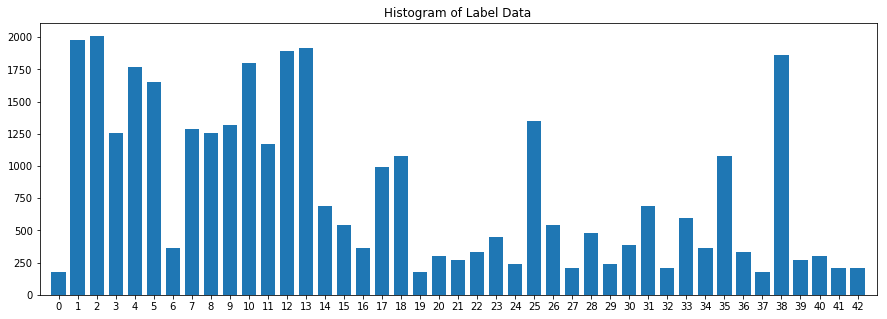

In [5]:
# Histogram of Training Data
plot_hist(y_train)

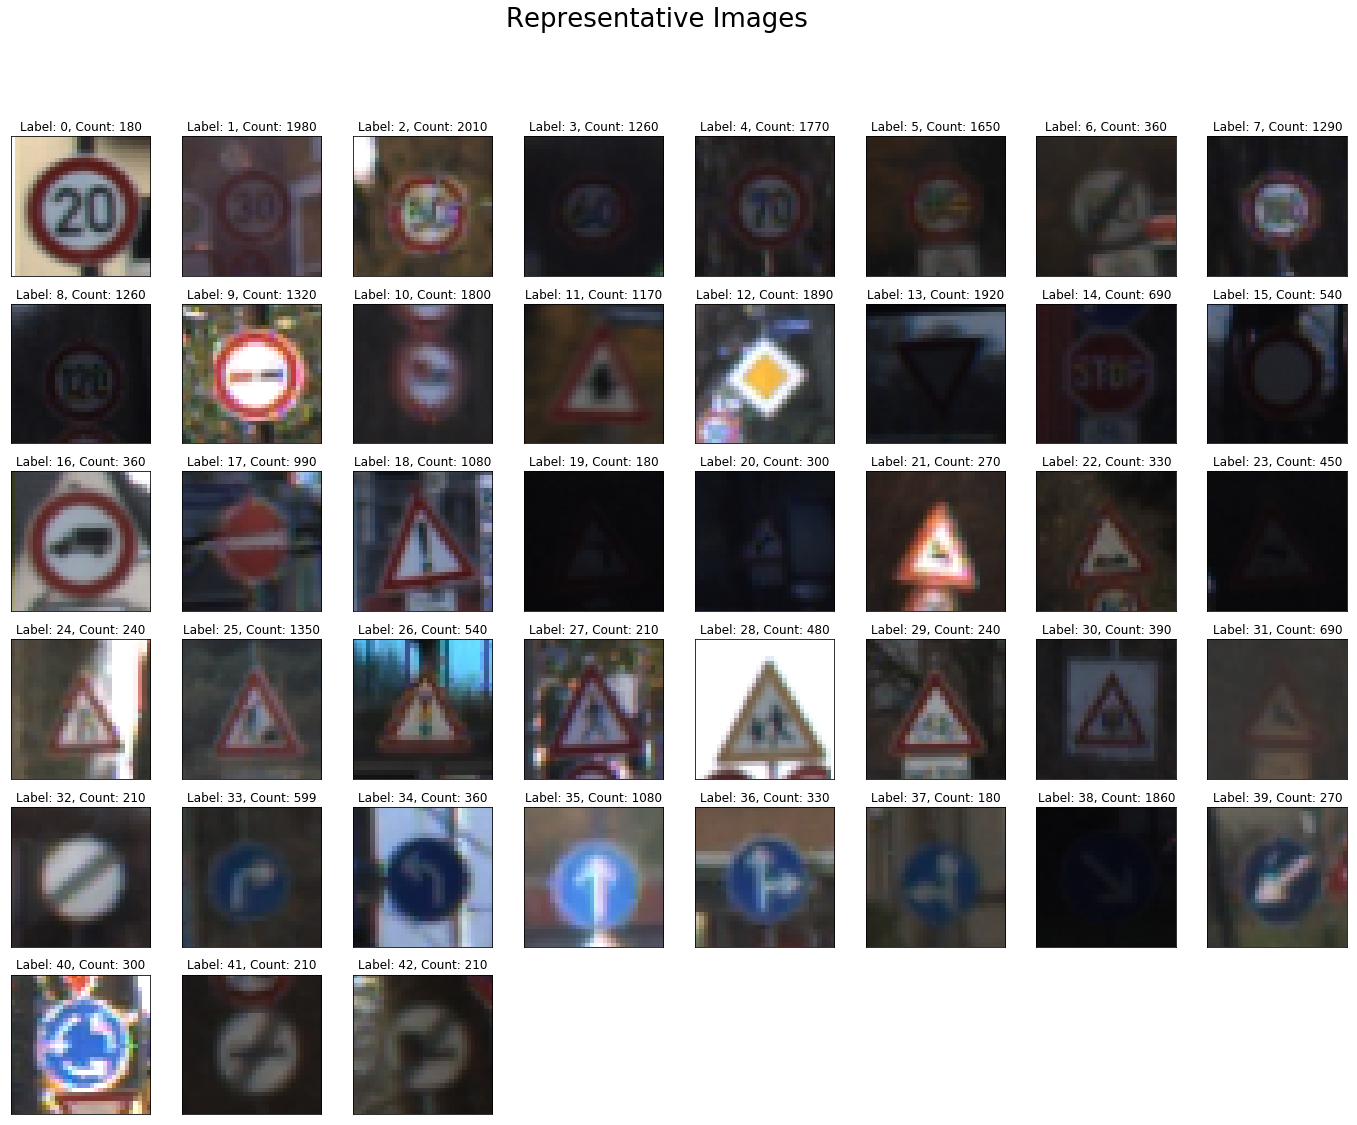

In [23]:
# Sample image from each class with image count
display_images(X_train, y_train)

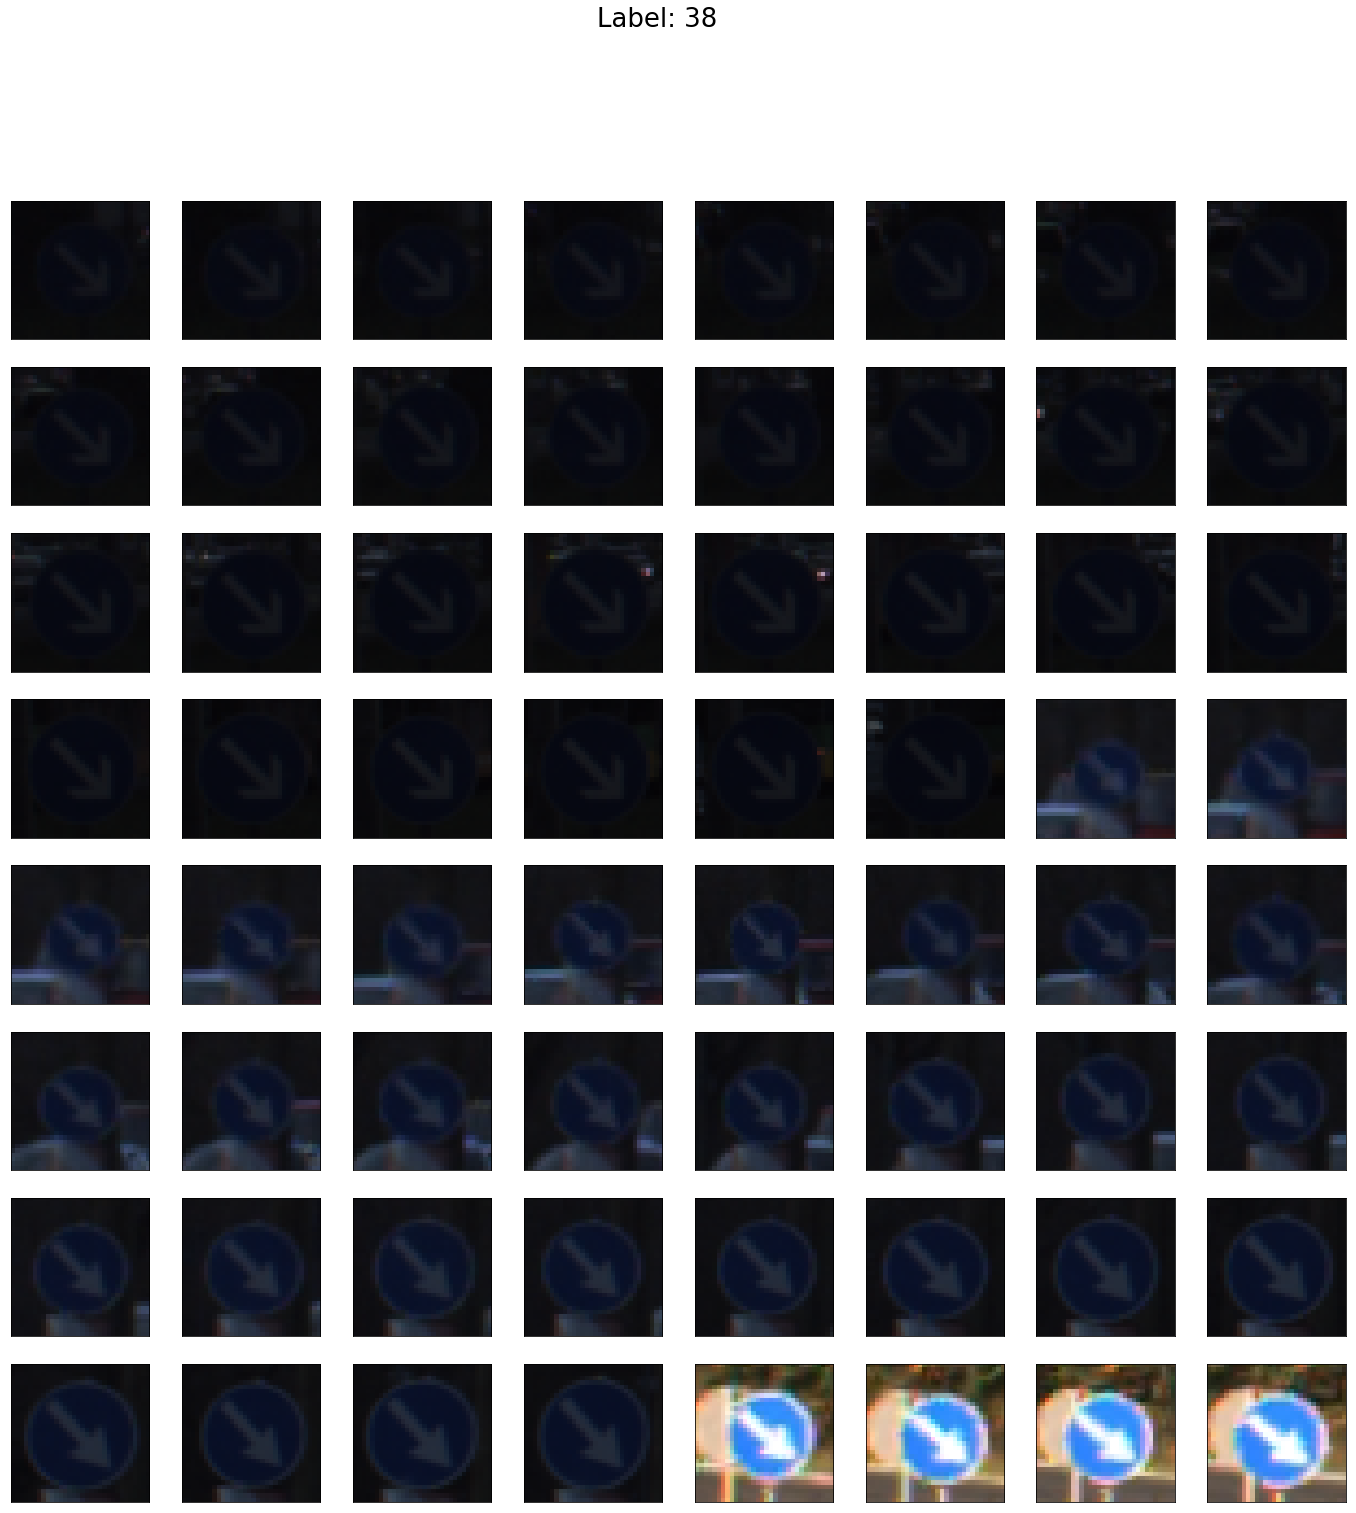

In [24]:
# Multiple samples of single image class
# This allows us to see the broad variation within a class
single_label(X_train, y_train, 38, 64)

### Pre-Process Data Set

In [6]:
# Define preprocessing functions
from tqdm import tqdm
import cv2

def grayscale(image):
    x = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    x = np.reshape(x, (x.shape[0], x.shape[1],1))
    return x
    

def normalize(image):
    img = image / 255
    img_mean = np.mean(image/255)
    return img - img_mean

def gray_norm(x):
    #x = grayscale(x)
    x = normalize(x)
    return x

def preprocess(images):
    x = np.zeros(shape=images.shape)
    channels = gray_norm(images[0]).shape[2]
    x = x[:,:,:,0:channels]
    for i in tqdm(range(images.shape[0])):
        x[i] = gray_norm(images[i])
    return x
        

def equalize_dist(images, labels):
    max_count = np.max(np.bincount(labels))
    n_classes = len(set(labels))
    image_ext = np.copy(images)
    label_ext = np.copy(labels)
    for idx in tqdm(range(n_classes)):
        indices = np.where(labels==idx)
        count = len(indices[0])
        if count == max_count:
            continue
        img_set = np.copy(images[indices])
        diff = max_count - count
        mult = diff//count
        end_idx = diff%count
        for i in range(mult):
            image_ext = np.append(image_ext,img_set, axis=0)
            label_ext = np.append(label_ext, np.repeat(idx,count))
        image_ext = np.append(image_ext, img_set[:end_idx], axis=0)
        label_ext = np.append(label_ext, np.repeat(idx, end_idx))
    
    return image_ext, label_ext

In [7]:
# Normalize images to have -1:1 range and zero mean
x_train = preprocess(X_train)
x_valid = preprocess(X_valid)
x_test = preprocess(X_test)

# Equalize distribution of training images per class
x_train, y_train = equalize_dist(x_train, y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [02:10<00:00,  7.04s/it]


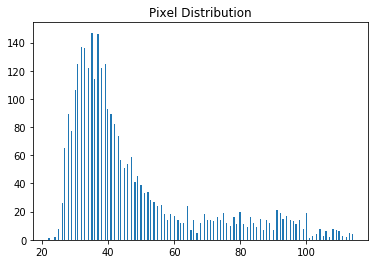

In [43]:
# Pixel distribution of sample image prior to normalization
pixel_dist(X_train, 30000)

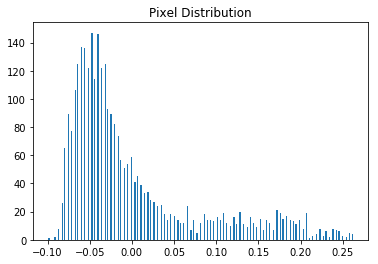

In [44]:
# Pixel distribution of sample image after normalization
pixel_dist(x_train, 30000)

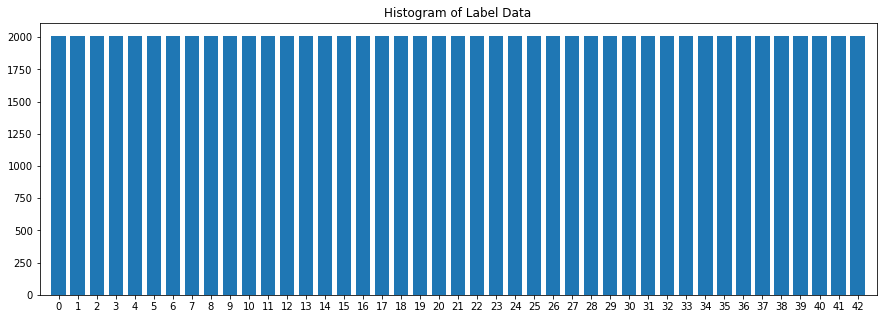

In [11]:
# Histogram of Training Data after equalization
plot_hist(y_train)

---
## Design and Test Model Architectures

### Library Imports, Hyperparameters & Image Augmentation Generator

In [8]:
# Import requisite libraries
import tensorflow as tf
import numpy as np
import keras
from keras.applications.vgg16 import VGG16
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential, load_model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
import os

In [9]:
# Hyperparameters & parameters
batch_size = 256
nb_classes = len(np.unique(y_train))
epochs = 100
num_predictions = 5
shape = x_train.shape[1:]

In [10]:
# Create image data augmentation generator
datagen = ImageDataGenerator(
    zca_whitening=False,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2)
          
datagen.fit(x_train)

---
### Model Architecture, Training and Validation: Lenet

In [11]:
# Build LeNet model with dropout to reduce overfitting
# Image augmentation generator applied to better generalize model training


# Lenet - Block 1
model = Sequential()

model.add(Conv2D(32, 3, 3, input_shape=(shape)))
model.add(Activation('relu'))                 
model.add(Conv2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Lenet - Block 2
model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))                 
model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Lenet - Block 3
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [12]:
# Model architecture overview
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 30, 30, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 30, 30, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 28, 28, 32)    9248        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 28, 28, 32)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [30]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train Model with image generator
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                    samples_per_epoch=x_train.shape[0],
                    nb_epoch=epochs, validation_data=(x_valid, y_valid),
                    callbacks=[ModelCheckpoint('lenet.h5', save_best_only=True)])


Epoch 1/100
86430/86430 [==============================] - 39s - loss: 2.4102 - acc: 0.2910 - val_loss: 1.5354 - val_acc: 0.5134
Epoch 2/100
86430/86430 [==============================] - 37s - loss: 1.1058 - acc: 0.6423 - val_loss: 1.1530 - val_acc: 0.6660
Epoch 3/100
86430/86430 [==============================] - 37s - loss: 0.6861 - acc: 0.7744 - val_loss: 0.8760 - val_acc: 0.7621
Epoch 4/100
86430/86430 [==============================] - 37s - loss: 0.4995 - acc: 0.8350 - val_loss: 0.7518 - val_acc: 0.7927
Epoch 5/100
86430/86430 [==============================] - 37s - loss: 0.3932 - acc: 0.8703 - val_loss: 0.6337 - val_acc: 0.8401
Epoch 6/100
86430/86430 [==============================] - 37s - loss: 0.3225 - acc: 0.8934 - val_loss: 0.5941 - val_acc: 0.8671
Epoch 7/100
86430/86430 [==============================] - 37s - loss: 0.2796 - acc: 0.9084 - val_loss: 0.5853 - val_acc: 0.8710
Epoch 8/100
86430/86430 [==============================] - 37s - loss: 0.2454 - acc: 0.9187 - val

86430/86430 [==============================] - 37s - loss: 0.0627 - acc: 0.9804 - val_loss: 0.3176 - val_acc: 0.9583
Epoch 65/100
86430/86430 [==============================] - 37s - loss: 0.0619 - acc: 0.9809 - val_loss: 0.2652 - val_acc: 0.9719
Epoch 66/100
86430/86430 [==============================] - 38s - loss: 0.0602 - acc: 0.9809 - val_loss: 0.2581 - val_acc: 0.9735
Epoch 67/100
86430/86430 [==============================] - 37s - loss: 0.0576 - acc: 0.9820 - val_loss: 0.2672 - val_acc: 0.9705
Epoch 68/100
86430/86430 [==============================] - 37s - loss: 0.0620 - acc: 0.9810 - val_loss: 0.2626 - val_acc: 0.9721
Epoch 69/100
86430/86430 [==============================] - 37s - loss: 0.0597 - acc: 0.9813 - val_loss: 0.3294 - val_acc: 0.9603
Epoch 70/100
86430/86430 [==============================] - 37s - loss: 0.0613 - acc: 0.9810 - val_loss: 0.2578 - val_acc: 0.9737
Epoch 71/100
86430/86430 [==============================] - 37s - loss: 0.0567 - acc: 0.9825 - val_loss

### Visualization of Results & Test Accuracy: Lenet

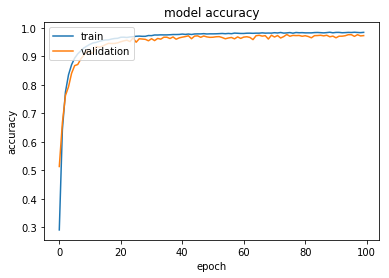

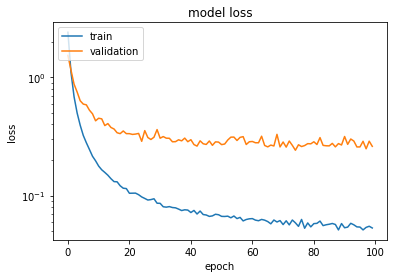

In [31]:
# Plot training/validation loss and accuracy data
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
# Load trained model
lenet = load_model('lenet.h5')

In [114]:
# Model performance on test set
score = lenet.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.235536605868
Test accuracy: 0.957957244703


---
### Model Architecture, Training and Testing: VGG16 Transfer Learning

In [14]:
# Build VGG16 model with pre-trained weights
# Train/fine-tune last 2 convolutional blocks
# Add last fully-connected layers for classification


# Base model: VGG16
inputs = Input(shape=shape)
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

# Freeze lower levels, fine-tune upper
for layer in base_model.layers[:10]:
    layer.trainable = False
for layer in base_model.layers[10:]:
    layer.trainable = True

# Add last fully-connected layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(p=0.5)(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(nb_classes, activation='softmax')(x)
model = Model(input=base_model.input, output=predictions)

In [13]:
# Model architecture overview
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 32, 32, 64)    1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 32, 32, 64)    36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 16, 16, 64)    0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [33]:
# Compile model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train Model
hist2 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                            samples_per_epoch=x_train.shape[0],
                            nb_epoch=epochs, validation_data=(x_valid, y_valid),
                            callbacks=[ModelCheckpoint('vgg16.h5', save_best_only=True)])

Epoch 1/100
86430/86430 [==============================] - 173s - loss: 1.8635 - acc: 0.3790 - val_loss: 1.7260 - val_acc: 0.4435
Epoch 2/100
86430/86430 [==============================] - 156s - loss: 0.7589 - acc: 0.7353 - val_loss: 1.1342 - val_acc: 0.6406
Epoch 3/100
86430/86430 [==============================] - 156s - loss: 0.4551 - acc: 0.8474 - val_loss: 0.8267 - val_acc: 0.7714
Epoch 4/100
86430/86430 [==============================] - 155s - loss: 0.3142 - acc: 0.8949 - val_loss: 0.8815 - val_acc: 0.7696
Epoch 5/100
86430/86430 [==============================] - 155s - loss: 0.2511 - acc: 0.9185 - val_loss: 0.8568 - val_acc: 0.7828
Epoch 6/100
86430/86430 [==============================] - 155s - loss: 0.2040 - acc: 0.9347 - val_loss: 0.8967 - val_acc: 0.7952
Epoch 7/100
86430/86430 [==============================] - 155s - loss: 0.1798 - acc: 0.9426 - val_loss: 0.8976 - val_acc: 0.8079
Epoch 8/100
86430/86430 [==============================] - 155s - loss: 0.1520 - acc: 0.95

### Visualization of Results & Test Accuracy: Fine-Tuned VGG16

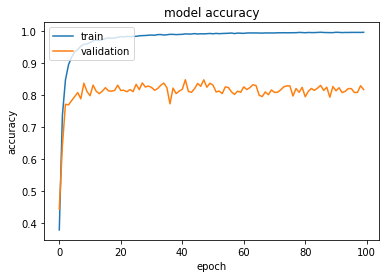

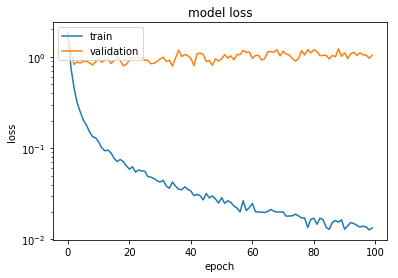

In [34]:
# Plot training/validation loss and accuracy data
plt.plot(hist2.history['acc'])
plt.plot(hist2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
# Load trained model
vgg16 = load_model('vgg16.h5')

In [344]:
# Model performance on test set
score = vgg16.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.838180618145
Test accuracy: 0.828028503572


---
## Test Models on New Images


### Load & Display Images to be Tested

In [15]:
### Assemble numpy array from resized sample images
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

folder = './signs/'
new_imgs = []

for image in os.listdir(folder):
    img = cv2.imread(folder+image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32,32), interpolation=cv2.INTER_AREA)
    new_imgs.append(img)
new_imgs = np.array(new_imgs)

### Build matching label array
new_labels = np.array([1,10,12,13,15,19,25,32,38])

In [16]:
### Make label key
sign_key = {}
with open('signnames.csv', 'r') as f:
    for line in f:
        data = line.strip().split(',')
        if data[0] == 'ClassId':
            continue
        sign_key[int(data[0])] = data[1]

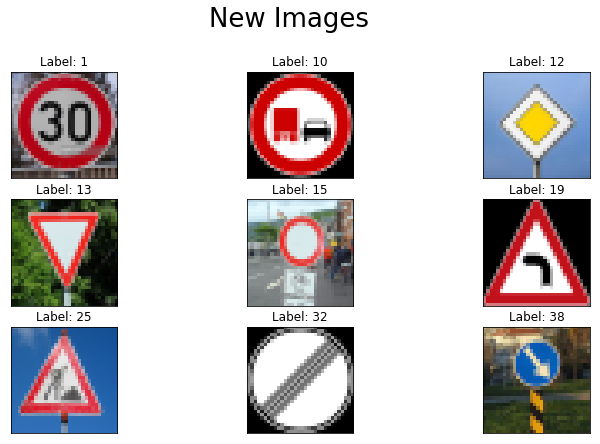

In [17]:
### Display images to be tested
fig = plt.figure(figsize=(4*3,3*3))
fig.suptitle('New Images', fontsize=26)

for i in range(new_imgs.shape[0]):
    label = new_labels[i]
    img = new_imgs[i]
    
    ax = fig.add_subplot(4, 3, i+1)
    ax.set_title('Label: %i' %(label))
    ax.set(xticks=[], yticks=[])
    ax.imshow(img.squeeze(),cmap='gray')


In [18]:
### Preprocess images
new_imgs_p = preprocess(new_imgs)

100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 8974.97it/s]


### Analyze Model Predictions for Each Image

In [21]:
### Produce prediction arrays
lenet_preds = lenet.predict(new_imgs_p)
vgg_preds = vgg16.predict(new_imgs_p)

In [22]:
### Extract top-k indices & softmax probabilities
top_k = 5

def top_probs(preds):
    indices = []
    probs = []
    for i in range(preds.shape[0]):
        img_probs = preds[i]
        refs = img_probs.argsort()[-top_k:]
        indices.append(refs)
        probs.append(img_probs[refs])
    indices = np.array(indices)
    probs = np.array(probs)
    indices = np.flip(indices, axis=1)
    probs = np.flip(probs, axis=1)
    
    return indices, probs

lenet_idx, lenet_prob = top_probs(lenet_preds)
vgg_idx, vgg_prob = top_probs(vgg_preds)

In [23]:
### Display model predictions
def show_preds(indices, probs):
    for i in range(len(indices)):
        print('')
        plt.imshow(new_imgs[i])
        plt.show()
        if new_labels[i] == indices[i][0]:
            out = 'Correct'
        else:
            out = 'Incorrect'
        print("")
        print('Predictions for Sample %s: %s' %(i+1, sign_key[new_labels[i]]))
        print("____________________________________________________________________________________________")
        print("")
        for j in range(len(indices[i])):
            print('Prediction %s: %s ==> \t \t %10.4f%%' %(j+1,sign_key[indices[i][j]],probs[i][j]*100))
        print("____________________________________________________________________________________________")
        print("")
        print('***Prediction is %s***' %(out))
        print("")
        print("")

### LeNet Results

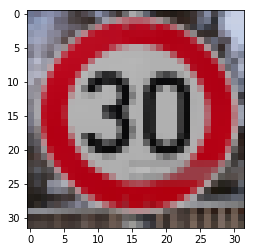


Predictions for Sample 1: Speed limit (30km/h)                              
____________________________________________________________________________________________

Prediction 1: Speed limit (30km/h)                               ==> 	 	    99.9998%
Prediction 2: Speed limit (20km/h)                               ==> 	 	     0.0002%
Prediction 3: Speed limit (50km/h)                               ==> 	 	     0.0000%
Prediction 4: Speed limit (80km/h)                               ==> 	 	     0.0000%
Prediction 5: Speed limit (70km/h)                               ==> 	 	     0.0000%
____________________________________________________________________________________________

***Prediction is Correct***





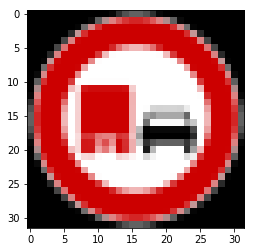


Predictions for Sample 2: No passing for vehicles over 3.5 metric tons      
____________________________________________________________________________________________

Prediction 1: No passing                                         ==> 	 	    70.5987%
Prediction 2: No passing for vehicles over 3.5 metric tons       ==> 	 	    29.4013%
Prediction 3: No entry                                           ==> 	 	     0.0000%
Prediction 4: Yield                                              ==> 	 	     0.0000%
Prediction 5: Road work                                          ==> 	 	     0.0000%
____________________________________________________________________________________________

***Prediction is Incorrect***





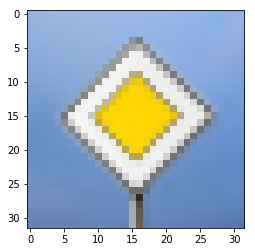


Predictions for Sample 3: Priority road                                     
____________________________________________________________________________________________

Prediction 1: Priority road                                      ==> 	 	   100.0000%
Prediction 2: Yield                                              ==> 	 	     0.0000%
Prediction 3: Keep left                                          ==> 	 	     0.0000%
Prediction 4: Traffic signals                                    ==> 	 	     0.0000%
Prediction 5: Right-of-way at the next intersection              ==> 	 	     0.0000%
____________________________________________________________________________________________

***Prediction is Correct***





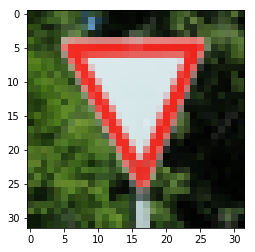


Predictions for Sample 4: Yield                                             
____________________________________________________________________________________________

Prediction 1: Yield                                              ==> 	 	   100.0000%
Prediction 2: Traffic signals                                    ==> 	 	     0.0000%
Prediction 3: No entry                                           ==> 	 	     0.0000%
Prediction 4: Speed limit (70km/h)                               ==> 	 	     0.0000%
Prediction 5: No passing                                         ==> 	 	     0.0000%
____________________________________________________________________________________________

***Prediction is Correct***





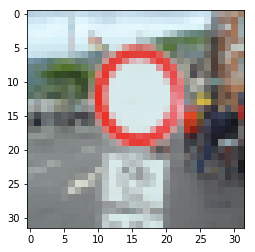


Predictions for Sample 5: No vehicles                                       
____________________________________________________________________________________________

Prediction 1: Yield                                              ==> 	 	    96.6302%
Prediction 2: No vehicles                                        ==> 	 	     3.3691%
Prediction 3: No passing                                         ==> 	 	     0.0006%
Prediction 4: Traffic signals                                    ==> 	 	     0.0001%
Prediction 5: Speed limit (70km/h)                               ==> 	 	     0.0000%
____________________________________________________________________________________________

***Prediction is Incorrect***





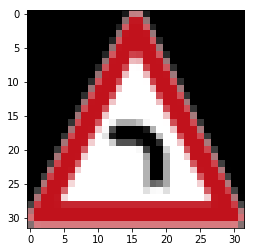


Predictions for Sample 6: Dangerous curve to the left                       
____________________________________________________________________________________________

Prediction 1: Dangerous curve to the left                        ==> 	 	    99.9931%
Prediction 2: Slippery road                                      ==> 	 	     0.0069%
Prediction 3: Double curve                                       ==> 	 	     0.0000%
Prediction 4: Wild animals crossing                              ==> 	 	     0.0000%
Prediction 5: No passing                                         ==> 	 	     0.0000%
____________________________________________________________________________________________

***Prediction is Correct***





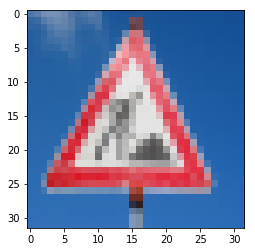


Predictions for Sample 7: Road work                                         
____________________________________________________________________________________________

Prediction 1: Road work                                          ==> 	 	   100.0000%
Prediction 2: Pedestrians                                        ==> 	 	     0.0000%
Prediction 3: Speed limit (120km/h)                              ==> 	 	     0.0000%
Prediction 4: Beware of ice/snow                                 ==> 	 	     0.0000%
Prediction 5: Stop                                               ==> 	 	     0.0000%
____________________________________________________________________________________________

***Prediction is Correct***





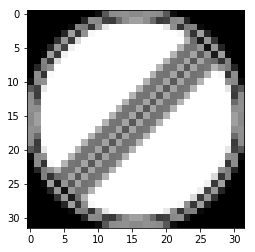


Predictions for Sample 8: End of all speed and passing limits               
____________________________________________________________________________________________

Prediction 1: End of all speed and passing limits                ==> 	 	    99.0250%
Prediction 2: End of no passing                                  ==> 	 	     0.3787%
Prediction 3: End of no passing by vehicles over 3.5 metric tons ==> 	 	     0.3262%
Prediction 4: Yield                                              ==> 	 	     0.1552%
Prediction 5: Priority road                                      ==> 	 	     0.1010%
____________________________________________________________________________________________

***Prediction is Correct***





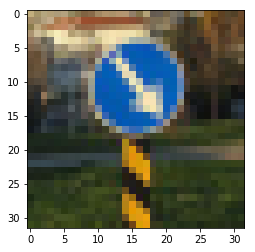


Predictions for Sample 9: Keep right                                        
____________________________________________________________________________________________

Prediction 1: Keep right                                         ==> 	 	    94.0052%
Prediction 2: Roundabout mandatory                               ==> 	 	     5.6609%
Prediction 3: Ahead only                                         ==> 	 	     0.2011%
Prediction 4: Speed limit (70km/h)                               ==> 	 	     0.0420%
Prediction 5: Speed limit (50km/h)                               ==> 	 	     0.0366%
____________________________________________________________________________________________

***Prediction is Correct***




In [41]:
show_preds(lenet_idx, lenet_prob)

### VGG16 Results

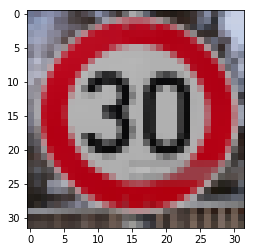


Predictions for Sample 1: Speed limit (30km/h)                              
____________________________________________________________________________________________

Prediction 1: Speed limit (30km/h)                               ==> 	 	    99.9940%
Prediction 2: Speed limit (50km/h)                               ==> 	 	     0.0053%
Prediction 3: Speed limit (20km/h)                               ==> 	 	     0.0007%
Prediction 4: Speed limit (70km/h)                               ==> 	 	     0.0000%
Prediction 5: Road work                                          ==> 	 	     0.0000%
____________________________________________________________________________________________

***Prediction is Correct***





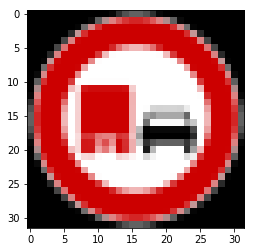


Predictions for Sample 2: No passing for vehicles over 3.5 metric tons      
____________________________________________________________________________________________

Prediction 1: No passing                                         ==> 	 	    97.3221%
Prediction 2: No passing for vehicles over 3.5 metric tons       ==> 	 	     1.2852%
Prediction 3: Keep right                                         ==> 	 	     0.8252%
Prediction 4: Speed limit (80km/h)                               ==> 	 	     0.0911%
Prediction 5: Speed limit (30km/h)                               ==> 	 	     0.0888%
____________________________________________________________________________________________

***Prediction is Incorrect***





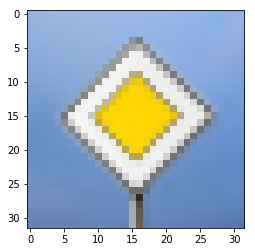


Predictions for Sample 3: Priority road                                     
____________________________________________________________________________________________

Prediction 1: Priority road                                      ==> 	 	   100.0000%
Prediction 2: Stop                                               ==> 	 	     0.0000%
Prediction 3: No entry                                           ==> 	 	     0.0000%
Prediction 4: No passing for vehicles over 3.5 metric tons       ==> 	 	     0.0000%
Prediction 5: Yield                                              ==> 	 	     0.0000%
____________________________________________________________________________________________

***Prediction is Correct***





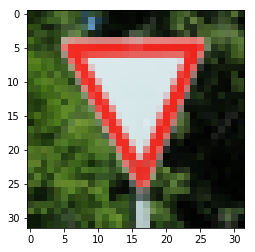


Predictions for Sample 4: Yield                                             
____________________________________________________________________________________________

Prediction 1: Yield                                              ==> 	 	   100.0000%
Prediction 2: Bumpy road                                         ==> 	 	     0.0000%
Prediction 3: No vehicles                                        ==> 	 	     0.0000%
Prediction 4: General caution                                    ==> 	 	     0.0000%
Prediction 5: Traffic signals                                    ==> 	 	     0.0000%
____________________________________________________________________________________________

***Prediction is Correct***





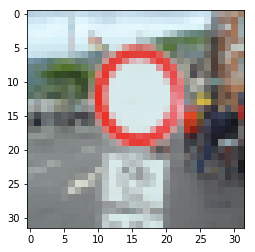


Predictions for Sample 5: No vehicles                                       
____________________________________________________________________________________________

Prediction 1: Yield                                              ==> 	 	    97.3284%
Prediction 2: Priority road                                      ==> 	 	     1.6932%
Prediction 3: No passing                                         ==> 	 	     0.4839%
Prediction 4: No vehicles                                        ==> 	 	     0.1771%
Prediction 5: No passing for vehicles over 3.5 metric tons       ==> 	 	     0.1340%
____________________________________________________________________________________________

***Prediction is Incorrect***





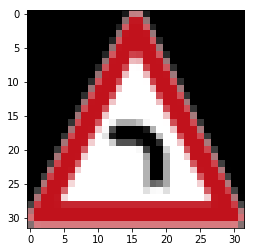


Predictions for Sample 6: Dangerous curve to the left                       
____________________________________________________________________________________________

Prediction 1: Dangerous curve to the left                        ==> 	 	    72.1999%
Prediction 2: Double curve                                       ==> 	 	    16.9515%
Prediction 3: Speed limit (30km/h)                               ==> 	 	     2.7556%
Prediction 4: Slippery road                                      ==> 	 	     2.1523%
Prediction 5: Dangerous curve to the right                       ==> 	 	     1.0827%
____________________________________________________________________________________________

***Prediction is Correct***





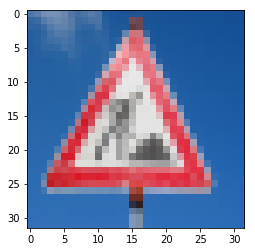


Predictions for Sample 7: Road work                                         
____________________________________________________________________________________________

Prediction 1: Road work                                          ==> 	 	    99.9987%
Prediction 2: Pedestrians                                        ==> 	 	     0.0004%
Prediction 3: Children crossing                                  ==> 	 	     0.0003%
Prediction 4: Traffic signals                                    ==> 	 	     0.0003%
Prediction 5: Wild animals crossing                              ==> 	 	     0.0001%
____________________________________________________________________________________________

***Prediction is Correct***





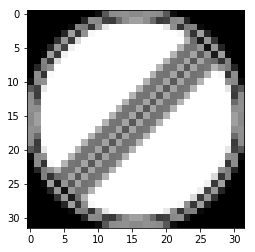


Predictions for Sample 8: End of all speed and passing limits               
____________________________________________________________________________________________

Prediction 1: End of all speed and passing limits                ==> 	 	    99.9158%
Prediction 2: No passing                                         ==> 	 	     0.0435%
Prediction 3: End of no passing                                  ==> 	 	     0.0161%
Prediction 4: No entry                                           ==> 	 	     0.0053%
Prediction 5: Speed limit (60km/h)                               ==> 	 	     0.0048%
____________________________________________________________________________________________

***Prediction is Correct***





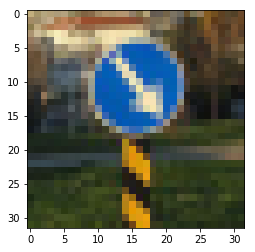


Predictions for Sample 9: Keep right                                        
____________________________________________________________________________________________

Prediction 1: Keep right                                         ==> 	 	    99.9912%
Prediction 2: Ahead only                                         ==> 	 	     0.0026%
Prediction 3: No passing                                         ==> 	 	     0.0025%
Prediction 4: Turn right ahead                                   ==> 	 	     0.0012%
Prediction 5: Roundabout mandatory                               ==> 	 	     0.0008%
____________________________________________________________________________________________

***Prediction is Correct***




In [24]:
show_preds(vgg_idx, vgg_prob)

### Comparative Performance: LeNet vs. VGG16

In [388]:
# LeNet vs. VGG16
lenet_new = lenet.evaluate(new_imgs_p, new_labels, verbose=0)
vgg16_new = vgg16.evaluate(new_imgs_p, new_labels, verbose=0)
print('LeNet Accuracy: %.3f%%'% (lenet_new[1]*100))
print('VGG16 Accuracy: %.3f%%'% (vgg16_new[1]*100))
print("")
print('LeNet Loss: %.5f'% (lenet_new[0]))
print('VGG16 Loss: %.5f'% (vgg16_new[0]))

LeNet Accuracy: 77.778%
VGG16 Accuracy: 77.778%

LeNet Loss: 0.52071
VGG16 Loss: 1.22412


### Review instances of incorrect prediction

First incorrectly classified image: 		 No passing for vehicles over 3.5 metric tons      
Incorrectly classified as: 			 No passing                                        


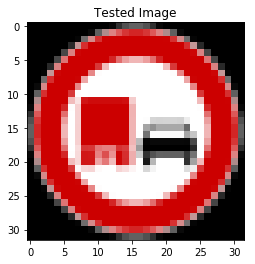

In [389]:
### First incorrect prediction
print('First incorrectly classified image: \t\t %s' %(sign_key[new_labels[1]]))
print('Incorrectly classified as: \t\t\t %s' %(sign_key[9]))
plt.title('Tested Image')
plt.imshow(new_imgs[1])
plt.show()

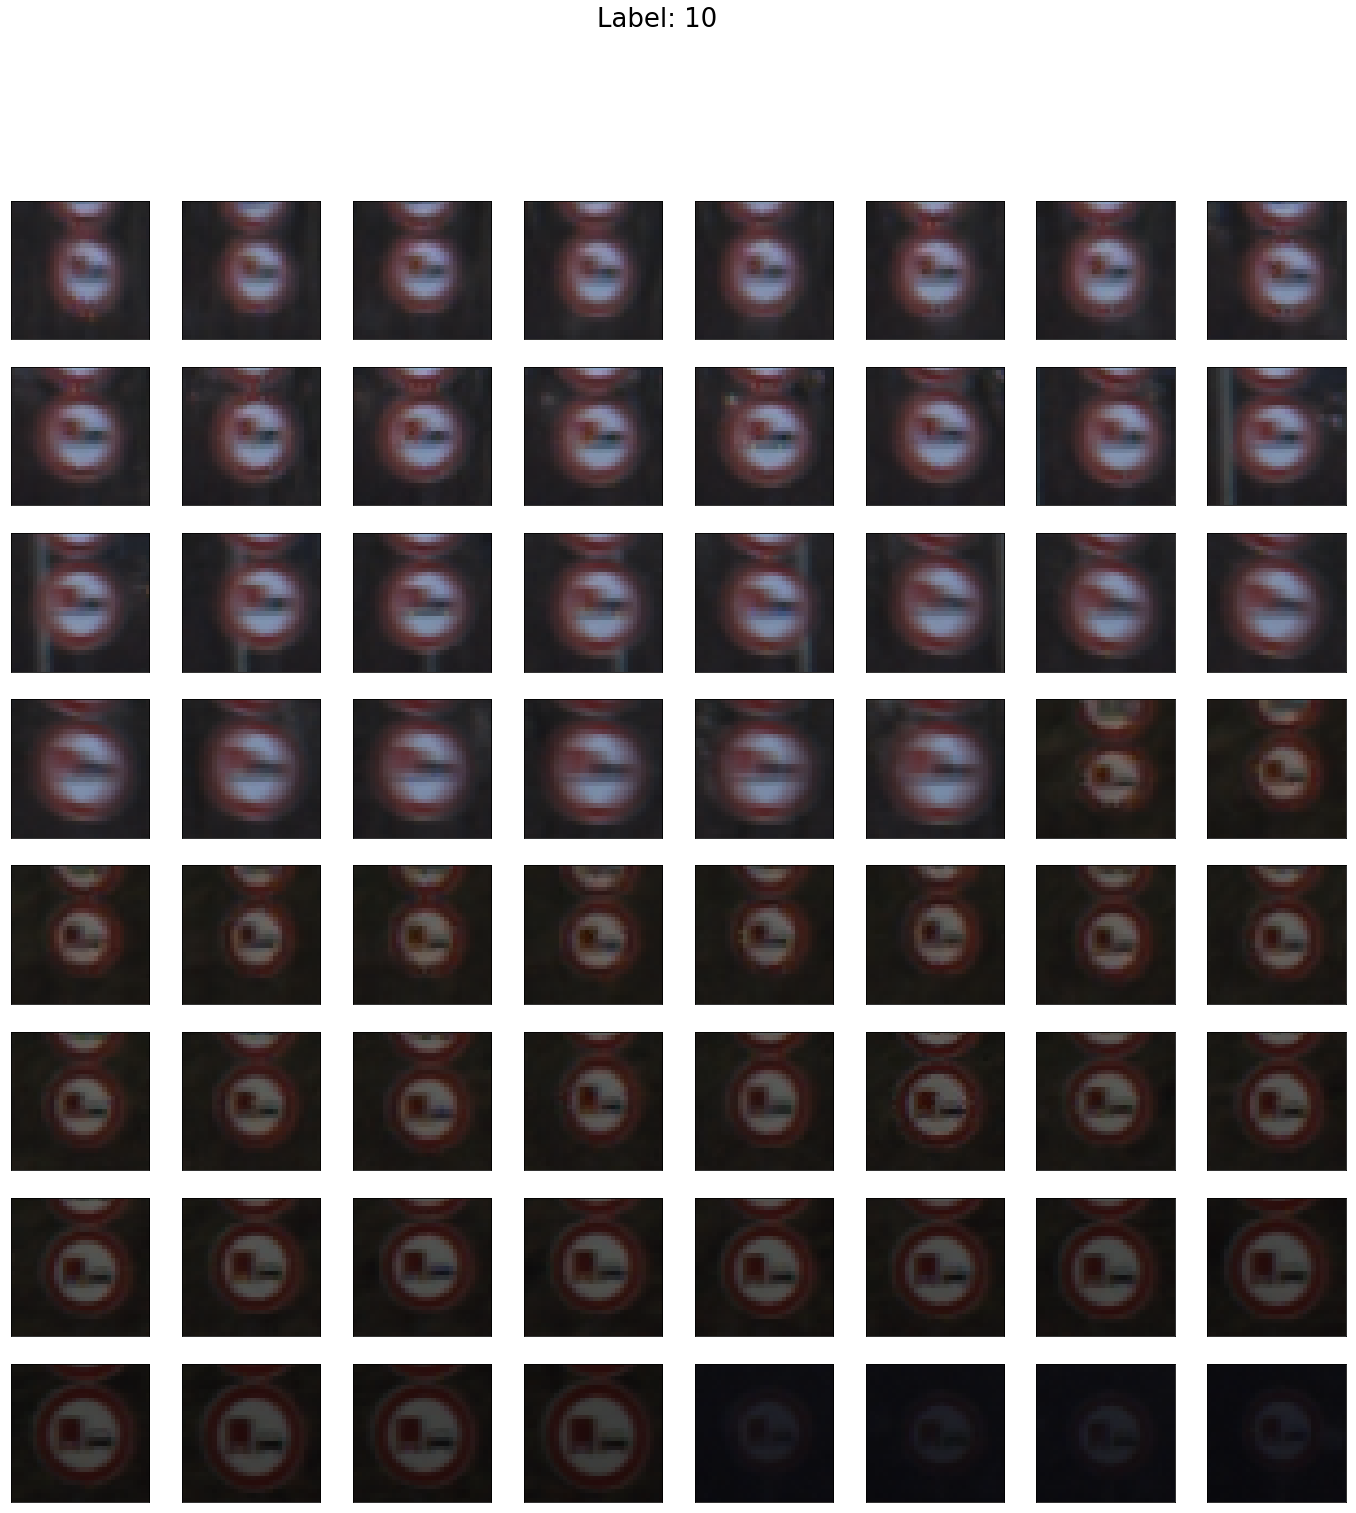

In [386]:
### Examples of incorrect classification images from training set
single_label(X_train, y_train, 10, 64)

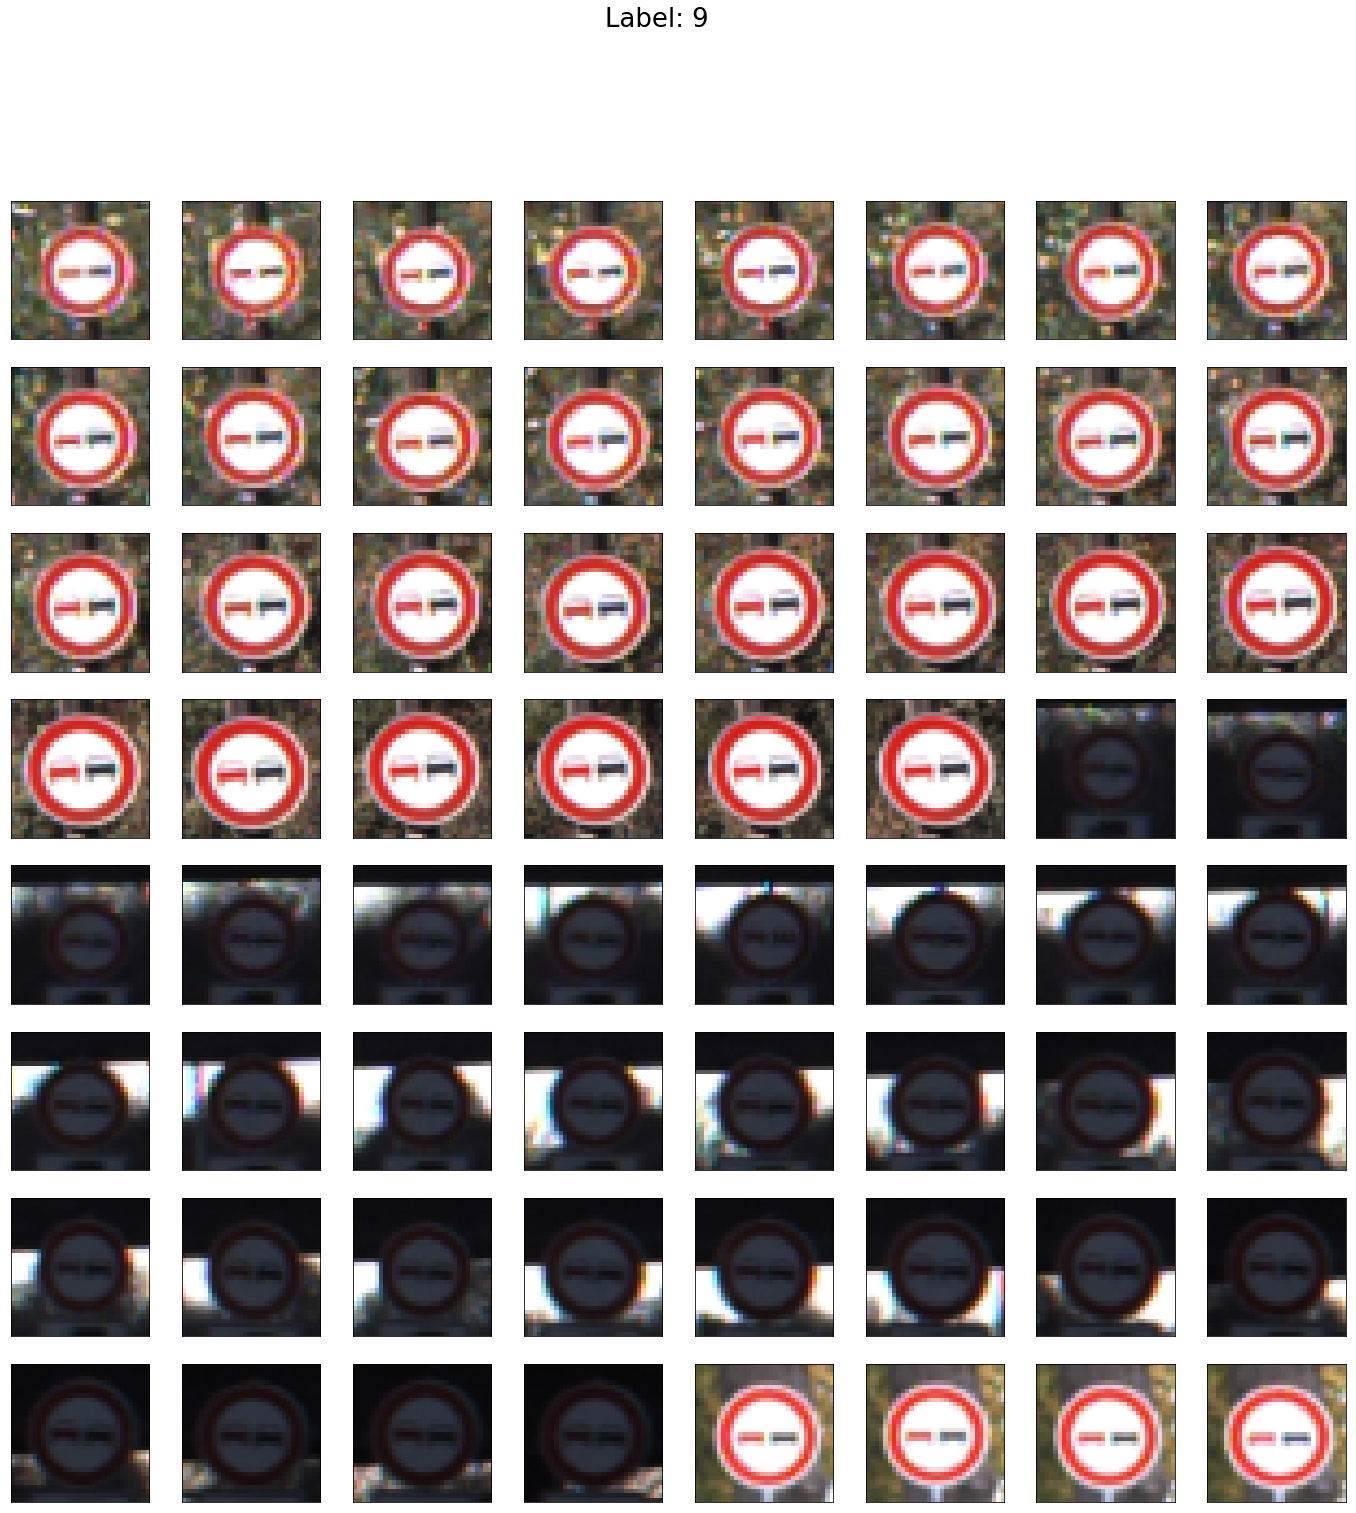

In [391]:
### Examples of correct classification images from training set
single_label(X_train, y_train, 9, 64)

##### Comment:

The two images look very similar, the only difference being that the red vehicle on the left is taller/larger in the 'No Passing: Vehicles over 3.5 tonnes' versus the normal 'No Passing' sign. Its easy to see how the models could have made this error. In both models, the correct prediction was second highest probability, with LeNet outperforming VGG16 in terms of certainty of correct class. 

Second incorrectly classified image: 		 No vehicles                                       
Incorrectly classified as: 			 Yield                                             


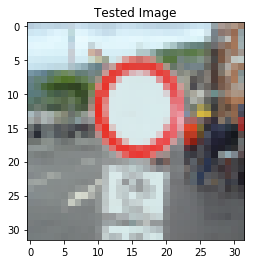

In [394]:
### Second incorrect prediction
print('Second incorrectly classified image: \t\t %s' %(sign_key[new_labels[4]]))
print('Incorrectly classified as: \t\t\t %s' %(sign_key[13]))
plt.title('Tested Image')
plt.imshow(new_imgs[4])
plt.show()

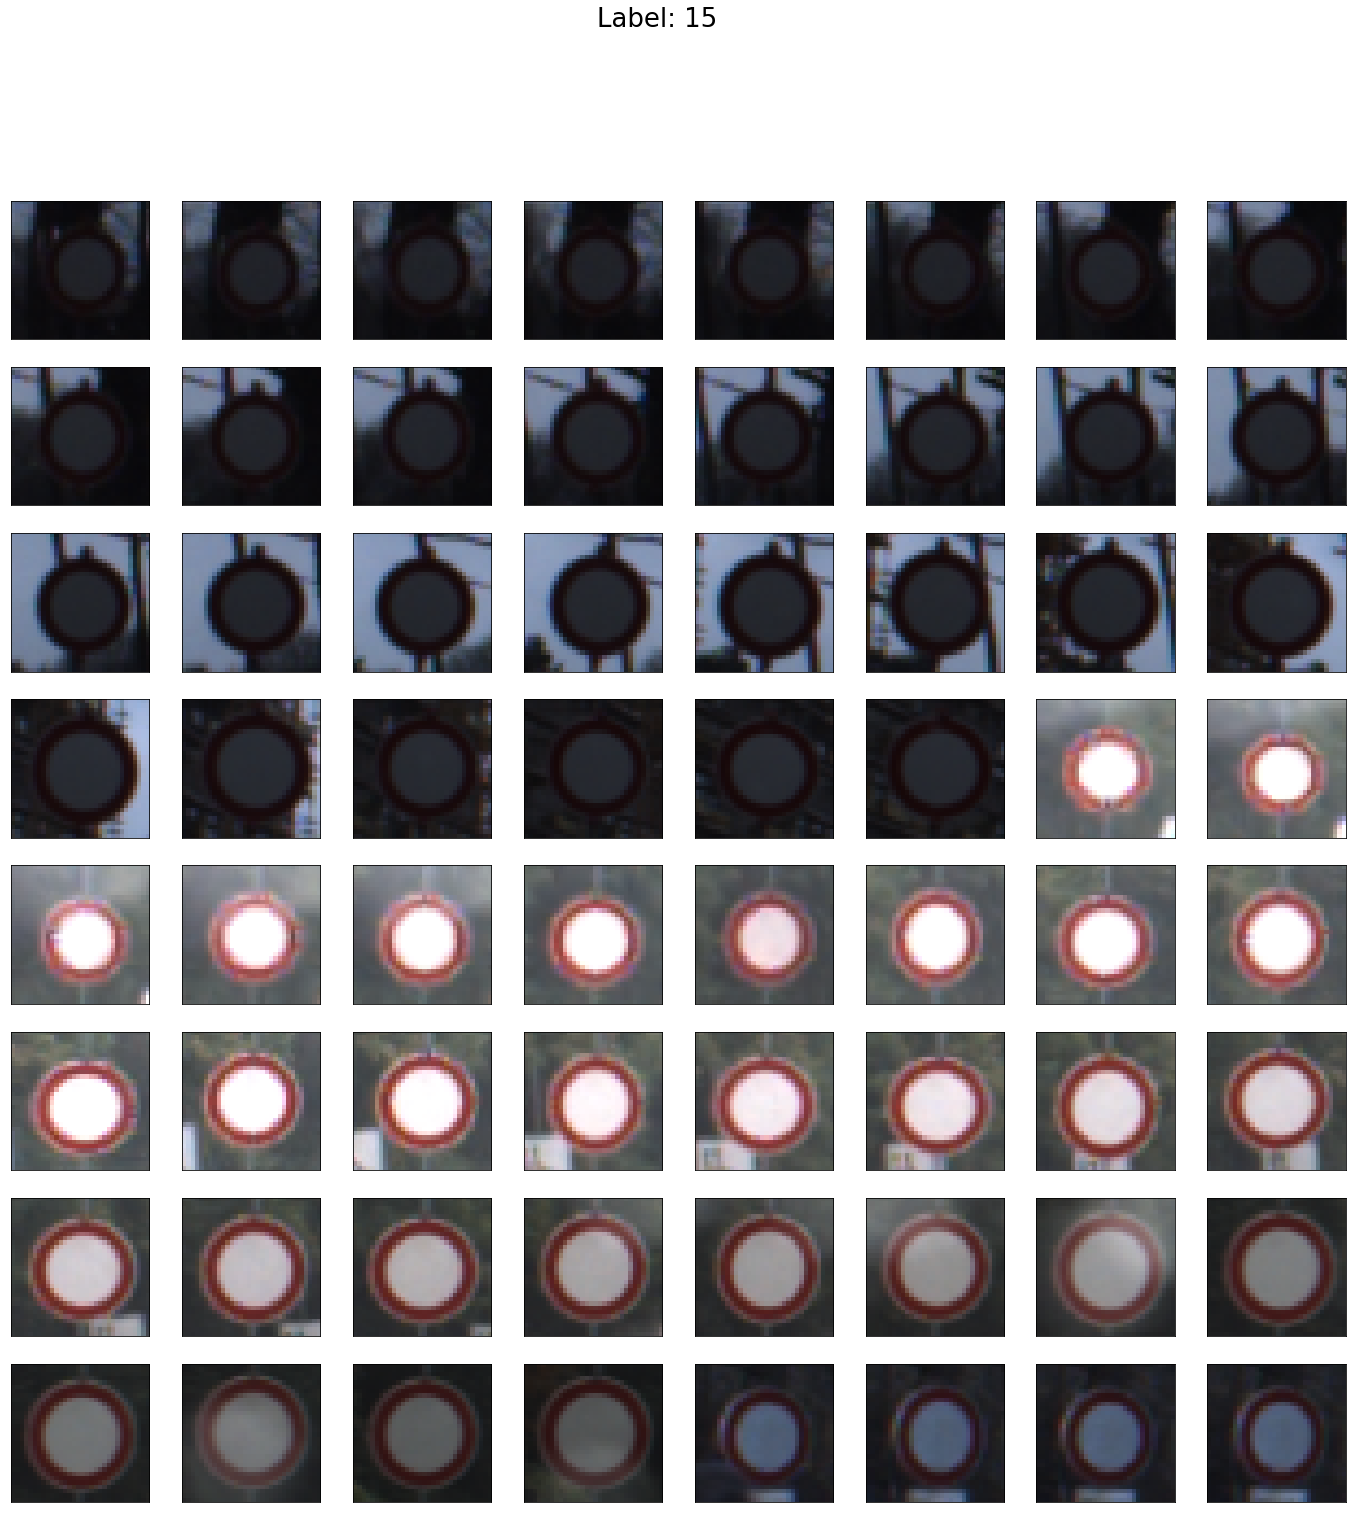

In [397]:
### Examples of incorrect classification images from training set
single_label(X_train, y_train, 15, 64)

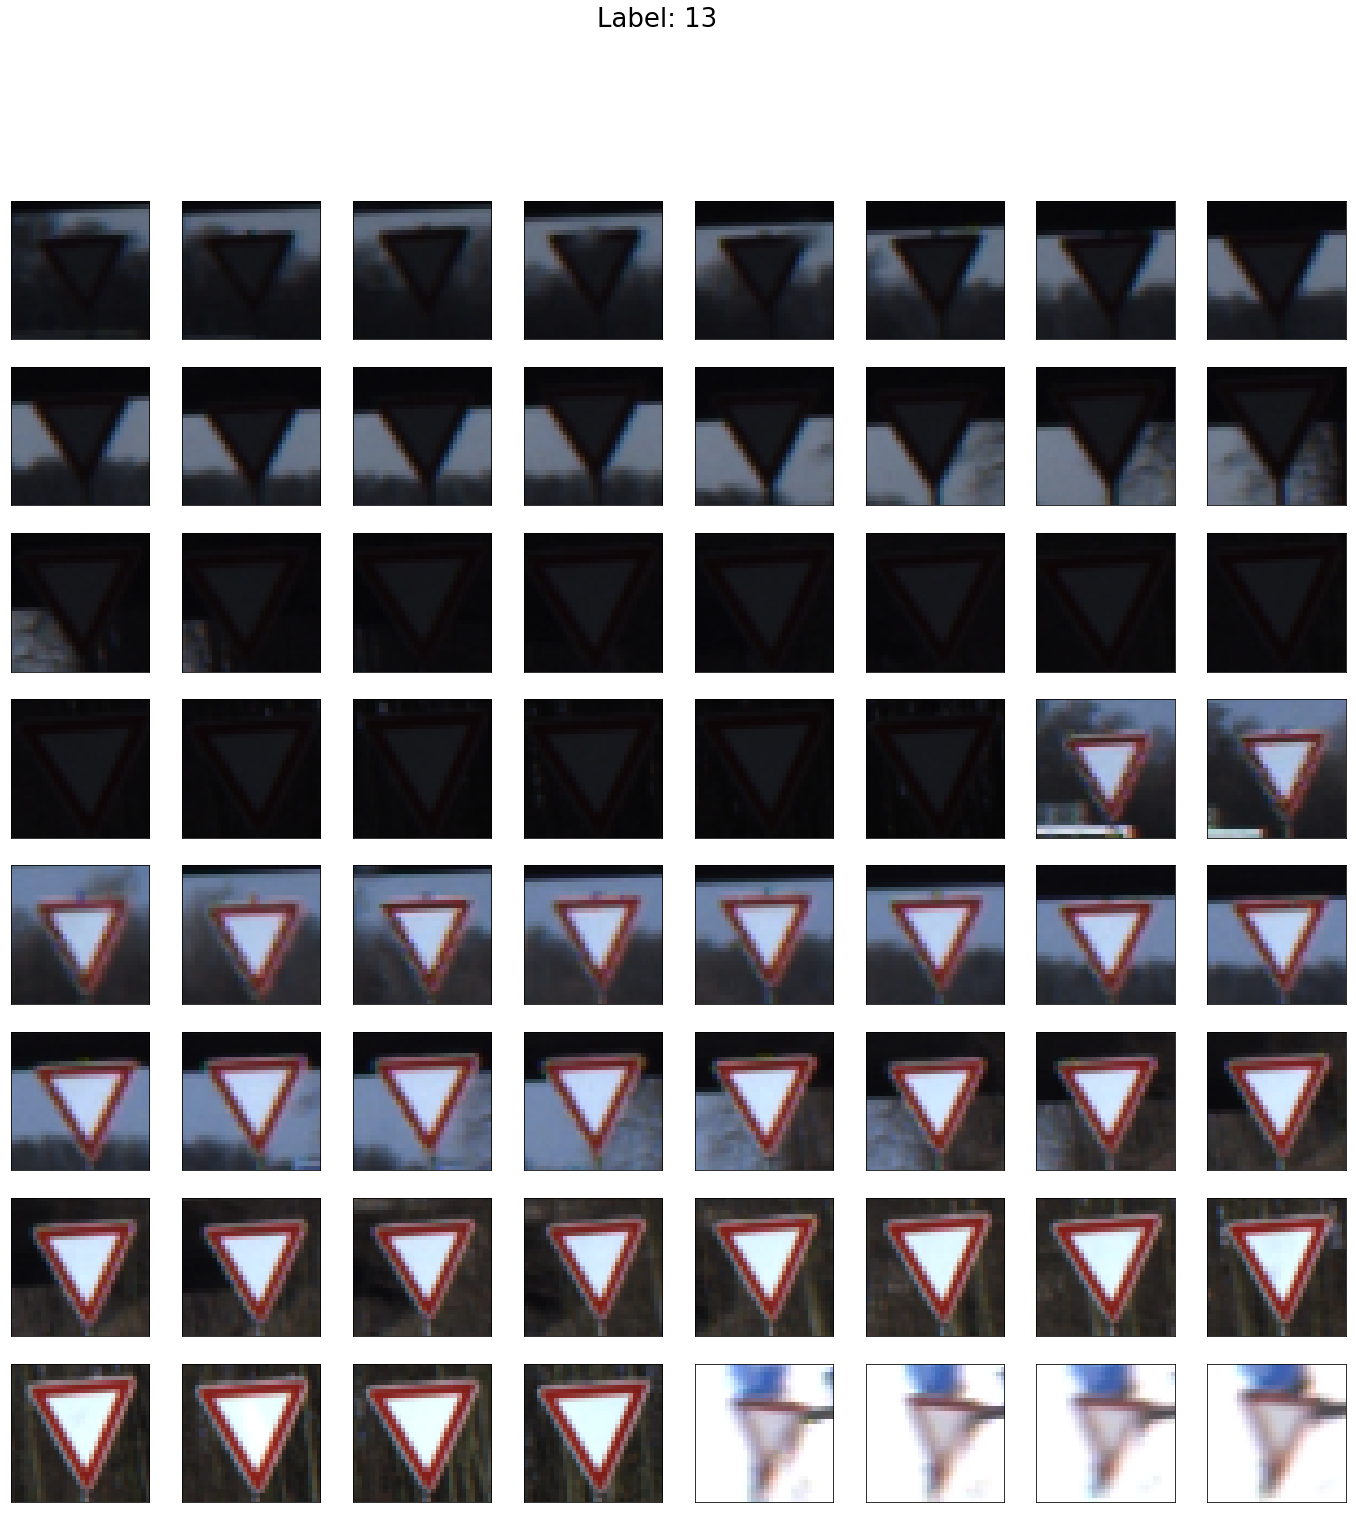

In [398]:
### Examples of correct classification images from training set
single_label(X_train, y_train, 13, 64)

##### Comment:

In the second instance, the 'Yield' sign was misclassified as 'No Vehicles' with a high level of confidence in both cases. Based on the triangle/circle shape difference, it seems like it should be a very easy classification to discern. The only similarity is the coloration of each, but it doesn't seem like this should be sufficient to outweigh the shape difference. Maybe if the models were trained with grayscale images, they would have relied more heavily on edges versus colors, which appears to be the issue in this case. In both models the correct prediction was second highest probability, with LeNet outperforming VGG16 in terms of certainty of correct class. 